Notebook for using a bag-of-words representation with a Logistic Regression model

**Imports**

In [1]:

import os
import json
import pathlib

import numpy as np
import pandas as pd
import sklearn as sk

import pyplotterlib.standard.plotters as ppl

import shared_code_path
import model_wrappers as modelWrapHelp
import standard_pipes as stdPipeHelp
import train_pipes as trainPipeHelp

2023-04-22 16:51:14.556996: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 16:51:14.558348: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 16:51:14.581831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 16:51:14.582353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 16:51:14.980823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

**Configuration Variables**

In [2]:
#
TRAIN_PATH = os.path.abspath( os.path.join("..","..","..","raw_data","train.csv") )
TEST_PATH = os.path.abspath( os.path.join("..","..","..","raw_data","test.csv") )

#
SAVE_FOLDER = os.path.abspath( "bow_lr_save_folder" )
SUBMISSIONS_PATH = os.path.join(SAVE_FOLDER, "submissions.csv")

#Can take a couple of minutes processing time to rerun; so preferably avoided
RERUN_HP_SEARCH = False
PATH_NGRAMS_1 = os.path.join(SAVE_FOLDER, "scores_ngrams_1.json")
PATH_NGRAMS_2 = os.path.join(SAVE_FOLDER, "scores_ngrams_2.json")
PATH_MAX_DF = os.path.join(SAVE_FOLDER, "scores_max_df.json")


#Hyperparameters to do a grid search over
MIN_DF_VALS = [1e-3, 2e-3, 3e-3, 4e-3]
C_VALS = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
MAX_DF_VALS = [6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 1e-1, 1.0]


In [3]:
np.random.seed(523423)

**Create save folder**

In [4]:
pathlib.Path(SAVE_FOLDER).mkdir(exist_ok=True)

**Import raw data**

In [5]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)
RAW_TRAIN.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


**Apply a standard text cleaning pipeline**

In [6]:
cleanPipe = stdPipeHelp.loadTextPreprocPipeA()
PROC_DATA = cleanPipe.fit_transform(RAW_TRAIN)

**Shuffle the data**

In [7]:
PROC_DATA = PROC_DATA.sample(frac=1.0)
PROC_DATA.head(2)

,id,keyword,location,text,target
663,958,blaze,Mo.City,@beautiful_juic1 just letting you know,0
2086,2998,dead,NaN,@atchisonsean he is dead,0


**Transform into a frame for each min_df/ngram range**

This SHOULD ideally be done at training time + this approach will lead to some data leakage. But its MUCH faster + likely wont affect the relative results too much

In [8]:
FRAME_ARRAY_NGRAMS_1, FRAME_ARRAY_NGRAMS_2 = list(), list()

for minDf in MIN_DF_VALS:
    _transformerA = trainPipeHelp.AddBagOfWords(vectKwargs={"min_df":minDf, "ngram_range":(1,1)})
    _transformerB = trainPipeHelp.AddBagOfWords(vectKwargs={"min_df":minDf, "ngram_range":(1,2)})
    
    _frameA = _transformerA.fit(PROC_DATA).transform(PROC_DATA.copy())
    _frameB = _transformerB.fit(PROC_DATA).transform(PROC_DATA.copy())
    
    FRAME_ARRAY_NGRAMS_1.append( _frameA )
    FRAME_ARRAY_NGRAMS_2.append( _frameB )
    

**Get cross-validation scores for each set of hyperparameters**

In [9]:
def fillScoreArray(inpArray, nGrams, printProgress=True):
    #
    if nGrams == 1:
        nGramOpt = (1,1)
        useFrames = FRAME_ARRAY_NGRAMS_1
    elif nGrams == 2:
        nGramOpt = (1,2)
        useFrames = FRAME_ARRAY_NGRAMS_2
    else:
        raise ValueError(nGrams)
    
    #
    _nJobsLeft = len(MIN_DF_VALS)*len(C_VALS)
    for rIdx,minDf in enumerate(MIN_DF_VALS):
        for cIdx, cVal in enumerate(C_VALS):
            useFrame = useFrames[rIdx]
            inpArray[rIdx][cIdx] = getScore(useFrame, cVal)
            _nJobsLeft -= 1
            if printProgress:
                print("{} jobs left".format(_nJobsLeft))
            
def getScore(inpFrame, cVal):
    modelKwargs = {"max_iter":1000}
    model = modelWrapHelp.LogRegressionClassifier( list(), featPrefix=["bow_"], C=cVal, modelKwargs=modelKwargs  )
    return np.mean( sk.model_selection.cross_val_score(model, inpFrame, n_jobs=5) )

Code for serializing/deserializing scores

**TODO: Factor this part out into a utils.py**

In [10]:
def writeScoreArrayToJson(outArray, outFile):
    with open(outFile,"wt") as f:
        json.dump(outArray.tolist(), f)

def readScoreArrayFromJson(inpFile):
    with open(inpFile,"rt") as f:
        output = json.load(f)
    return np.array(output)



This is for ngrams = 1 (i.e. individual words only)

In [11]:
%%prun
#          104626 function calls (100449 primitive calls) in 57.115 seconds

if RERUN_HP_SEARCH:
    SCORE_ARRAY_NGRAM_1 = np.zeros( (len(MIN_DF_VALS),len(C_VALS))   )
    fillScoreArray(SCORE_ARRAY_NGRAM_1, nGrams=1)
    writeScoreArrayToJson(SCORE_ARRAY_NGRAM_1, PATH_NGRAMS_1)
else:
    SCORE_ARRAY_NGRAM_1 = readScoreArrayFromJson(PATH_NGRAMS_1)

This is for ngrams = 2

In [12]:
%%prun
#          96672 function calls (92464 primitive calls) in 81.773 seconds

if RERUN_HP_SEARCH:
    SCORE_ARRAY_NGRAM_2 = np.zeros( (len(MIN_DF_VALS),len(C_VALS))   )
    fillScoreArray(SCORE_ARRAY_NGRAM_2, nGrams=2)
    writeScoreArrayToJson(SCORE_ARRAY_NGRAM_2, PATH_NGRAMS_2)
else:
    SCORE_ARRAY_NGRAM_2 = readScoreArrayFromJson(PATH_NGRAMS_2)

**Visualise the hyperparameter search results**

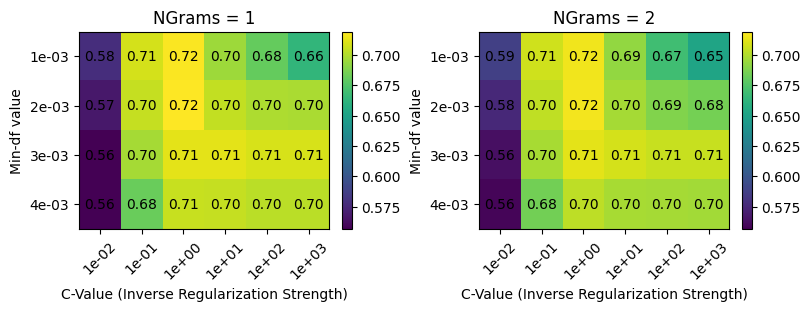

In [13]:
#Create the template heatmap plotter
_minColorVal = min( [np.min(x) for x in [SCORE_ARRAY_NGRAM_1, SCORE_ARRAY_NGRAM_2]] )
_maxColorVal = max( [np.max(x) for x in [SCORE_ARRAY_NGRAM_1, SCORE_ARRAY_NGRAM_2]] )
_currKwargs = {"annotateVals":True,
               "annotateValsStrFmt":"{:.2f}",
               "figSizeOnCreation":(4,3),
               "colorBarShow":True,
               "colorMapMaxVal":_maxColorVal,
               "colorMapMinVal":_minColorVal,
               "groupLabelsCols":["{:.0e}".format(x) for x in C_VALS],
               "groupLabelsColsRotation":45,
               "groupLabelsRows":["{:.0e}".format(x) for x in MIN_DF_VALS],
               "xLabelStr": "C-Value (Inverse Regularization Strength)",
               "yLabelStr": "Min-df value"
              }
heatPlotter = ppl.DiscreteHeatMapPlotter(**_currKwargs)

#Create separate plotter for both nGrams=1 and nGrams=2
_nGramsOnePlotter = heatPlotter.createFactory(plotData=SCORE_ARRAY_NGRAM_1, titleStr="NGrams = 1")
_nGramsTwoPlotter = heatPlotter.createFactory(plotData=SCORE_ARRAY_NGRAM_2, titleStr="NGrams = 2")

#Create a grid plotter
_currKwargs = {"constrainedLayout":True,"figHeightPerRow":3, "figWidthPerCol":4, "nColsGrid":2}
gridPlotter = ppl.RectMultiPlotter(**_currKwargs)
_unused = gridPlotter.createPlot(plotters=[_nGramsOnePlotter, _nGramsTwoPlotter])

**Conclusions**

1) NGrams = 2 makes very little difference compared to NGrams=1

2) Min_df = 4e-3 gives a sufficiently large vocabulary (around 500 words for NGram=1)

3) A high min-df combined with low to medium regularization (High to medium C) leads to ~ the best model 

**Tune max_df values using min_df=4e-3 and nGrams=1**

In [14]:
MAX_DF_FRAMES = list()
_sharedMinDf = 4e-3

for maxDf in MAX_DF_VALS:
    _transformer = trainPipeHelp.AddBagOfWords(vectKwargs={"min_df":_sharedMinDf,
                                                           "ngram_range":(1,1),
                                                           "max_df":maxDf})
    _frame = _transformer.fit(PROC_DATA).transform(PROC_DATA.copy())
    MAX_DF_FRAMES.append( _frame )
    



In [15]:
def fillScoreArray_maxDf(inpArray, printProgress=True):
    #
    useFrames = MAX_DF_FRAMES
    _nJobsLeft = len(MAX_DF_VALS)*len(C_VALS)
    for rIdx,maxDf in enumerate(MAX_DF_VALS):
        for cIdx, cVal in enumerate(C_VALS):
            useFrame = useFrames[rIdx]
            inpArray[rIdx][cIdx] = getScore(useFrame, cVal)
            _nJobsLeft -= 1
            if printProgress:
                print("{} jobs left".format(_nJobsLeft))


In [16]:
%%prun
#          145022 function calls (138710 primitive calls) in 13.672 seconds

if RERUN_HP_SEARCH:
    SCORE_ARRAY_MAX_DF = np.zeros( (len(MAX_DF_VALS),len(C_VALS))   )
    fillScoreArray_maxDf(SCORE_ARRAY_MAX_DF)
    writeScoreArrayToJson(SCORE_ARRAY_MAX_DF, PATH_MAX_DF)
else:
    SCORE_ARRAY_MAX_DF = readScoreArrayFromJson(PATH_MAX_DF)

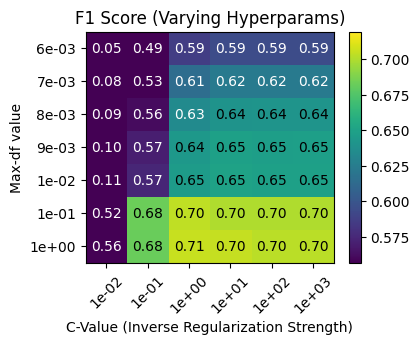

In [17]:
_currKwargs = {"annotateValsTextColor":['white',"black"],
              "groupLabelsRows":["{:.0e}".format(x) for x in MAX_DF_VALS],
               "plotData":SCORE_ARRAY_MAX_DF,
               "titleStr":"F1 Score (Varying Hyperparams)",
               "yLabelStr":"Max-df value"}

_unused = heatPlotter.createFactory(**_currKwargs).createPlot()


**Create a final model with the best hyperparameters**

In [18]:
cValue, maxDf, minDf = 1e1, 1e0, 1e-4
trainPipe = trainPipeHelp.AddBagOfWords(vectKwargs={"max_df":maxDf, "min_df":minDf})

FINAL_MODEL = modelWrapHelp.LogRegressionClassifier(feats=list(), featPrefix=["bow_"], trainPipe=trainPipe,
                                                    C=cValue, modelKwargs={"max_iter":1000})

**Look at the cross-validation score for this model when run with no data leakage**

In [19]:
cvScores = sk.model_selection.cross_val_score(FINAL_MODEL, PROC_DATA)
print(cvScores)
print(np.mean(cvScores))

[0.72955975 0.70443815 0.73617407 0.70280036 0.70699433]
0.71599333172014


**Retrain on the full dataset**

In [20]:
FINAL_MODEL.fit(PROC_DATA)

LogRegressionClassifier(C=10.0, featPrefix=['bow_'], feats=[],
                        modelKwargs={'max_iter': 1000}, penalty='l2',
                        trainPipe=<train_pipes.AddBagOfWords object at 0x7f505fb8af80>)

**Double checck our output model has good accuracy on the train set**

In [22]:
trainPred = FINAL_MODEL.predict(PROC_DATA)
_deltaVals = [ abs(pred-act) for pred,act in zip(trainPred,PROC_DATA["target"].to_numpy()) ]
trainAcc = (len(_deltaVals)-sum(_deltaVals)) / len(_deltaVals)

In [23]:
print("Training accuracy = {}".format(trainAcc))

Training accuracy = 0.9969892473118279


**Apply the model to the test data set**

In [24]:
RAW_TEST = pd.read_csv(TEST_PATH)
RAW_TEST.head(2)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


In [25]:
testCleanPipe = stdPipeHelp.loadTextPreprocPipeA(removeDuplicateTweets=False)
testCleanPipe.fit(RAW_TRAIN)

#
PROC_TEST = testCleanPipe.transform(RAW_TEST)
PROC_TEST["target"] = FINAL_MODEL.predict(PROC_TEST)
PROC_TEST.head(8)

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,0
1,2,NaN,NaN,"heard about #earthquake is different cities , ...",1
2,3,NaN,NaN,"there is a forest fire at spot pond , geese ar...",1
3,9,NaN,NaN,apocalypse lighting . #spokane #wildfires,1
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,1
5,12,NaN,NaN,we are shaking . it is an earthquake,1
6,21,NaN,NaN,they ' d probably still show more life than ar...,0
7,22,NaN,NaN,hey ! how are you ?,0


**Write our predictions to file in the correct format**

Kaggle Score = 0.78148

In [26]:
outFrame = PROC_TEST[["id","target"]]
outFrame.to_csv(SUBMISSIONS_PATH, index=False)

In [27]:
outFrame

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
